In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
import datetime
from copy import deepcopy
from datas import *
import warnings
# 忽略future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

# 一、数据准备

## 1.1 读取日度行情表

表内字段就是 Backtrader 默认情况下要求输入的 7 个字段： 'datetime' 、'open'、'high'、'low'、'close'、'volume'、'openinterest'，外加一个 'sec_code' 股票代码字段。

In [2]:
year = 2016
start_date = f'2016-04-30'
end_date = f'2020-04-30'

list_assets, df_assets = get_hs300_stocks(f'{year}-01-01')

missing_assets = [
    "600005", "600068", "600432", "600832", 
    "601268", "601299", "601558", 
    "000024", "000527", "000562", "000780"
]

# 生成完整的交易日索引
all_dates = pd.date_range(start=start_date, end=end_date, freq='B')  # 频率为交易日

list_assets = [asset for asset in list_assets if asset not in missing_assets]

df_org= get_all_date_data(start_date, end_date, list_assets)

# df_org.to_csv('data/df_org.csv')/
# df_org = pd.read_csv('data/df_org.csv', dtype={'asset': str})
# df_org = df_org[(df_org['date'] >= start_date)& (df_org['date'] <= end_date) ] #

df1 = df_org.rename(columns={
                        "date": "datetime", 
                        "asset": "sec_code"})

df1["openinterest"] = 0

daily_price=df1[['sec_code','datetime', "open", "close", "high", "low", "volume", 'openinterest']]

daily_price['datetime'] = pd.to_datetime(daily_price['datetime'])

# # 以 datetime 为 index，类型为 datetime 或 date 类型，Datafeeds 默认情况下是将 index 匹配给 datetime 字段；
daily_price = daily_price.set_index(['datetime'])

# daily_price.to_csv('data/daily_price.csv')
daily_price

login success!
login respond error_code:0
login respond  error_msg:success
query_hs300 error_code:0
query_hs300  error_msg:success
logout success!
297


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3828\1849039832.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_price['datetime'] = pd.to_datetime(daily_price['datetime'])


,sec_code,open,close,high,low,volume,openinterest
datetime,,,,,,,
2016-05-03,600000,17.95,18.12,18.24,17.83,277767,0
2016-05-04,600000,18.06,18.08,18.23,18.02,231190,0
2016-05-05,600000,18.06,18.06,18.12,17.98,149366,0
2016-05-06,600000,18.07,17.73,18.10,17.71,234068,0
2016-05-09,600000,17.71,17.51,17.80,17.40,219476,0
...,...,...,...,...,...,...,...
2020-04-24,300315,5.56,5.37,5.57,5.34,285243,0
2020-04-27,300315,5.39,5.33,5.42,5.27,240034,0
2020-04-28,300315,5.31,5.26,5.39,5.10,283141,0


## 1.2 生成调仓信息表

表内数据说明：

+ trade_date： 调仓期（每月最后一个交易日）;

+ sec_code：持仓成分股；

+ weight：持仓权重。

In [3]:

df_2 = df_org[['date', 'asset', "close"]]
df_2['date'] = pd.to_datetime(df_2['date'])
# print(df_all)

close = df_2.pivot(index='date', columns='asset', values='close')
# close = df_2.copy()
# close.columns = ['date', 'asset', 'close_price']
# close = close.pivot(index='date', columns='asset', values='close_price')

# 把close的date转换为日期格式
# close.index = pd.to_datetime(close.index)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3828\3362568559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['date'] = pd.to_datetime(df_2['date'])


In [4]:
alphaset = 'ourAlphas'
subset = '20130430'
alpha_name = 'alpha_CTA'

# 读取已经计算好的因子
alpha = pd.read_csv('alphas/{}/{}/{}.csv'.format(alphaset, subset, alpha_name))

# 筛选出今年的数据，确保日期在start_date和end_date之间
alpha = alpha[(alpha['date'] >= start_date) & (alpha['date'] <= end_date)] 

# 获取close中的所有有效资产
valid_assets = close.columns

# 筛选出alpha中的有效资产
alpha = alpha[['date'] + [col for col in alpha.columns if col in valid_assets]]

In [5]:
# 因子矩阵转换为一维数据(alphalens需要的格式)
alpha = alpha.melt(id_vars=['date'], var_name='asset', value_name='factor')

# date列转为日期格式
alpha['date'] = pd.to_datetime(alpha['date'])
alpha = alpha[['date', 'asset', 'factor']]

# 设置二级索引
alpha = alpha.set_index(['date', 'asset'], drop=True)
alpha.sort_index(inplace=True)

print(alpha.head())  # 查看因子数据的索引和格式
print(alpha.isna().mean() * 100)  # 查看缺失值比例

                     factor
date       asset           
2016-05-03 000001  0.000000
           000002  0.000000
           000009  0.645914
           000039  0.105058
           000046  0.758755
factor    0.0
dtype: float64


In [6]:
from alphalens.utils import get_clean_factor_and_forward_returns, compute_forward_returns, get_clean_factor
ret1 = compute_forward_returns(alpha, close, periods=[1, 5, 10])

ret = get_clean_factor(alpha, ret1, quantiles=5, max_loss=1)
# ret = get_clean_factor_and_forward_returns(alpha, close, quantiles=5, max_loss=1, periods=[1, 5, 10])
ret = ret.reset_index()
ret = ret[ret['factor_quantile'] == 5]

ret = ret[['date','asset']]
ret['weight'] = 1/60
trade_info = ret.rename(columns={""
        "date": "trade_date", 
        "asset": "sec_code"})
trade_info

fwdret_amount: 189150.0
quantile data
date        date        asset 
2016-05-03  2016-05-03  000001    1
                        000002    1
                        000009    4
                        000039    2
                        000046    4
                                 ..
2020-04-30  2020-04-30  601988    1
                        601989    5
                        601991    1
                        601992    3
                        601998    1
Name: factor_quantile, Length: 189150, dtype: int64
After resetting index:
date        asset 
2016-05-03  000001    1
            000002    1
            000009    4
            000039    2
            000046    4
                     ..
2020-04-30  601988    1
            601989    5
            601991    1
            601992    3
            601998    1
Name: factor_quantile, Length: 189150, dtype: int64
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see p

,trade_date,sec_code,weight
16,2016-05-03,000559,0.016667
27,2016-05-03,000728,0.016667
30,2016-05-03,000776,0.016667
32,2016-05-03,000783,0.016667
36,2016-05-03,000858,0.016667
...,...,...,...
189136,2020-04-30,601888,0.016667
189139,2020-04-30,601901,0.016667
189141,2020-04-30,601928,0.016667
189142,2020-04-30,601933,0.016667


# 二、 回测分析

## 2.1 加载策略和数据

In [7]:
# 回测策略
class TestStrategy(bt.Strategy):
    params = (
        ('buy_stocks', None), # 传入各个调仓日的股票列表和相应的权重
    )
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')

    def __init__(self):
         
        self.trade_dates = pd.to_datetime(self.p.buy_stocks['trade_date'].unique()).tolist()
        
        pd.DataFrame(self.trade_dates).to_csv('data/trade_dates.csv')
        
        self.buy_stock = self.p.buy_stocks # 保留调仓信息
        self.order_list = []  # 记录以往订单，在调仓日要全部取消未成交的订单
        self.buy_stocks_pre = [] # 记录上一期持仓
    
    def next(self):
        # 获取当前的回测时间点
        dt = self.datas[0].datetime.date(0)
        # 打印当前时刻的总资产
        self.log('当前总资产 %.2f' %(self.broker.getvalue()))
        # 如果是调仓日，则进行调仓操作
        
        dt = pd.Timestamp(dt)
        
        if dt in self.trade_dates:
            print(f"--------------{dt} 为调仓日----------")
            
            #取消之前所下的没成交也未到期的订单
            if len(self.order_list) > 0:
                print("--------------- 撤销未完成的订单 -----------------")
                for od in self.order_list:
                    # 如果订单未完成，则撤销订单
                    self.cancel(od) 
                 #重置订单列表
                self.order_list = [] 

            # 提取当前调仓日的持仓列表
            buy_stocks_data = self.buy_stock.query(f"trade_date=='{dt}'")
            long_list = buy_stocks_data['sec_code'].tolist()
            print('long_list', long_list)  # 打印持仓列表

            # 对现有持仓中，调仓后不再继续持有的股票进行卖出平仓
            sell_stock = [i for i in self.buy_stocks_pre if i not in long_list]
            print('sell_stock', sell_stock)
            if sell_stock:
                print("-----------对不再持有的股票进行平仓--------------")
                for stock in sell_stock:
                    data = self.getdatabyname(stock)
                    if self.getposition(data).size > 0 :
                        od = self.close(data=data)  
                        self.order_list.append(od) # 记录卖出订单

            # 买入此次调仓的股票：多退少补原则
            print("-----------买入此次调仓期的股票--------------")
            for stock in long_list:
                w = buy_stocks_data.query(f"sec_code=='{stock}'")['weight'].iloc[0] # 提取持仓权重
                data = self.getdatabyname(stock)
                order = self.order_target_percent(data=data, target=w*0.95) # 为减少可用资金不足的情况，留 5% 的现金做备用
                self.order_list.append(order)

            self.buy_stocks_pre = long_list  # 保存此次调仓的股票列表
        
    #订单日志    
    def notify_order(self, order):
        # 未被处理的订单
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 已被处理的订单
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, ref:%.0f, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Stock: %s' %
                    (order.ref,
                     order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     order.executed.size,
                     order.data._name))
            else:  # Sell
                self.log('SELL EXECUTED, ref:%.0f, Price: %.2f, Cost: %.2f, Comm %.2f, Size: %.2f, Stock: %s' %
                        (order.ref,
                         order.executed.price,
                         order.executed.value,
                         order.executed.comm,
                         order.executed.size,
                         order.data._name))

# 实例化大脑
cerebro_ = bt.Cerebro() 

# 按股票代码，依次循环传入数据
for stock in daily_price['sec_code'].unique():
    # 日期对齐
    data = pd.DataFrame(index=daily_price.index.unique())
    df = daily_price.query(f"sec_code=='{stock}'")[['open','high','low','close','volume','openinterest']]
    data_ = pd.merge(data, df, left_index=True, right_index=True, how='left')
    data_.loc[:,['volume','openinterest']] = data_.loc[:,['volume','openinterest']].fillna(0)
    data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].fillna(method='pad')
    # data_.loc[:,['open','high','low','close']] = data_.loc[:,['open','high','low','close']].fillna(0)
    # datafeed = bt.feeds.PandasData(dataname=data_, fromdate=datetime.datetime(year,1,1), todate=datetime.datetime(year+1,1,1))
    datafeed = bt.feeds.PandasData(dataname=data_, fromdate=pd.Timestamp(start_date), todate=pd.Timestamp(end_date))
    cerebro_.adddata(datafeed, name=stock)
    # print(f"{stock} Done !") 

## 2.2 添加分析器并执行回测

In [8]:
cerebro = deepcopy(cerebro_)  # 深度复制已经导入数据的 cerebro_，避免重复导入数据 
# 初始资金 100,000,000    
cerebro.broker.setcash(100000.0) 
# cerebro.broker.setcommission(commission=0.0015)
# 添加策略
cerebro.addstrategy(TestStrategy, buy_stocks=trade_info) # 通过修改参数 buy_stocks ，使用同一策略回测不同的持仓列表

# 添加分析指标
# 返回年初至年末的年度收益率
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='_AnnualReturn')
# 计算最大回撤相关指标
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_DrawDown')
# 计算年化收益
cerebro.addanalyzer(bt.analyzers.Returns, _name='_Returns', tann=252)
# 计算年化夏普比率
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_SharpeRatio', timeframe=bt.TimeFrame.Days, annualize=True, riskfreerate=0) # 计算夏普比率
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='_SharpeRatio_A')
# 返回收益率时序
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='_TimeReturn')

# 启动回测
result = cerebro.run()

2016-05-03, 当前总资产 100000.00
--------------2016-05-03 00:00:00 为调仓日----------
long_list ['000559', '000728', '000776', '000783', '000858', '002024', '002038', '002399', '002415', '002500', '600009', '600085', '600109', '600150', '600252', '600271', '600276', '600315', '600518', '600519', '600588', '600600', '600660', '600703', '600837', '600875', '600887', '600999', '601098', '601258', '601377', '601555', '601688', '601788', '601888', '601901', '601919', '601958', '601989']
sell_stock []
-----------买入此次调仓期的股票--------------
2016-05-04, BUY EXECUTED, ref:1, Price: 15.70, Cost: 1554.30, Comm 0.00, Size: 99.00, Stock: 000559
2016-05-04, BUY EXECUTED, ref:2, Price: 17.19, Cost: 1564.29, Comm 0.00, Size: 91.00, Stock: 000728
2016-05-04, BUY EXECUTED, ref:3, Price: 16.16, Cost: 1567.52, Comm 0.00, Size: 97.00, Stock: 000776
2016-05-04, BUY EXECUTED, ref:4, Price: 9.53, Cost: 1562.92, Comm 0.00, Size: 164.00, Stock: 000783
2016-05-04, BUY EXECUTED, ref:5, Price: 30.90, Cost: 1575.90, Comm 0.00,

## 2.3 回测结果分析

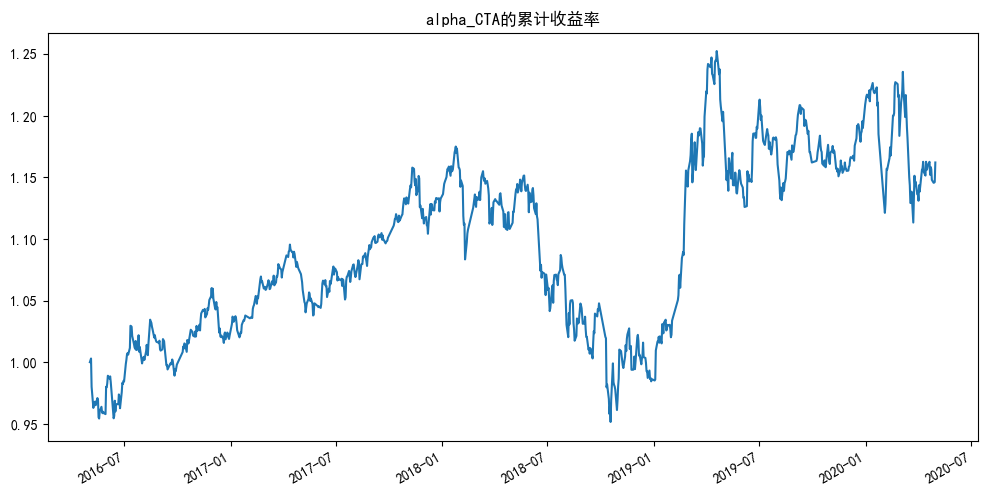

,年度,收益率,日均收益率,年化收益率,最大回撤(%),夏普比率
0,2016,0.150254,0.000154,0.039599,-19.028586,0.368517


In [ ]:
strat = result[0]
# print("--------------- AnnualReturn -----------------")
# print(strat.analyzers._AnnualReturn.get_analysis())
# print("--------------- DrawDown -----------------")
# print(strat.analyzers._DrawDown.get_analysis())
# print("--------------- Returns -----------------")
# print(strat.analyzers._Returns.get_analysis())
# print("--------------- SharpeRatio -----------------")
# print(strat.analyzers._SharpeRatio.get_analysis())
# print("--------------- SharpeRatio_A -----------------")
# print(strat.analyzers._SharpeRatio_A.get_analysis())

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'SimHei'

# 假设 strat.analyzers._TimeReturn.get_analysis() 已经返回了一个pandas Series对象
ret = pd.Series(strat.analyzers._TimeReturn.get_analysis())
# 计算累计收益率并绘图
((ret + 1).cumprod()).plot(figsize=(12,6))

plt.title(f'{alpha_name}的累计收益率')
# 保存图像
plt.savefig(f'output_charts/{alpha_name}.png')
plt.show()

ret = [{
        '年度': year,
        '收益率': strat.analyzers._Returns.get_analysis()['rtot'],
        '日均收益率': strat.analyzers._Returns.get_analysis()['ravg'],
        '年化收益率': strat.analyzers._Returns.get_analysis()['rnorm'],
        '最大回撤(%)': strat.analyzers._DrawDown.get_analysis()['max']['drawdown']
        * (-1),
        '夏普比率': strat.analyzers._SharpeRatio.get_analysis()['sharperatio'],
    }]
pd.DataFrame(ret).sort_values(by='年化收益率', ascending=False)

In [12]:
# 保存结果
pd.DataFrame(ret).to_csv(f'results/{alpha_name}.csv', index=False)

In [ ]:
class AnnualAnalysis(bt.Analyzer):
    def __init__(self):
        self.yearly_data = {}  # 存储按年份的结果

    def notify_trade(self, trade):
        if trade.isclosed:
            year = self.strategy.data.datetime.date(0).year
            pnl = trade.pnl  # 记录平仓盈亏
            if year not in self.yearly_data:
                self.yearly_data[year] = {'pnl': 0, 'trades': 0}
            self.yearly_data[year]['pnl'] += pnl
            self.yearly_data[year]['trades'] += 1

    def get_analysis(self):
        return self.yearly_data


class MyStrategy(bt.Strategy):
    def __init__(self):
        pass

    def next(self):
        # 策略逻辑
        pass


# 回测代码
if __name__ == '__main__':
    cerebro = bt.Cerebro()

    # 数据加载
    data = bt.feeds.YahooFinanceData(dataname='AAPL', fromdate=datetime(2015, 1, 1), todate=datetime(2020, 12, 31))
    cerebro.adddata(data)

    # 添加策略
    cerebro.addstrategy(MyStrategy)

    # 添加分析器
    cerebro.addanalyzer(AnnualAnalysis, _name='annual')

    # 运行回测
    results = cerebro.run()

    # 提取分析器结果
    strat = results[0]
    annual_data = strat.analyzers.annual.get_analysis()

    # 打印按年份的结果
    for year, data in annual_data.items():
        print(f"年度: {year}, 平仓盈亏: {data['pnl']}, 交易次数: {data['trades']}")
